# Skin Cancer Detection Model
### Special Thanks to:
- KonG for the Data Loader and Display functions: https://www.kaggle.com/kocayinana/skin-cancer-recognition-with-resnet-50
- Martin Kondor for the Metrics Plots: https://www.kaggle.com/martinkondor/skin-cancer-detection-with-cnn

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

In [3]:
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

# Loading & Preprocessing

I use a Ben & Cropping Method to preprocess the images, such that details and colors are enhanced

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/train/benign',224))
malign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/train/malignant',224))
benign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/test/benign',224))
malign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/test/malignant',224))

100%|██████████| 300/300 [00:01<00:00, 248.64it/s]


# Create Label

In [5]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split
Now we can split it into a training and validation set.

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=SEED
)

# Display Some Images

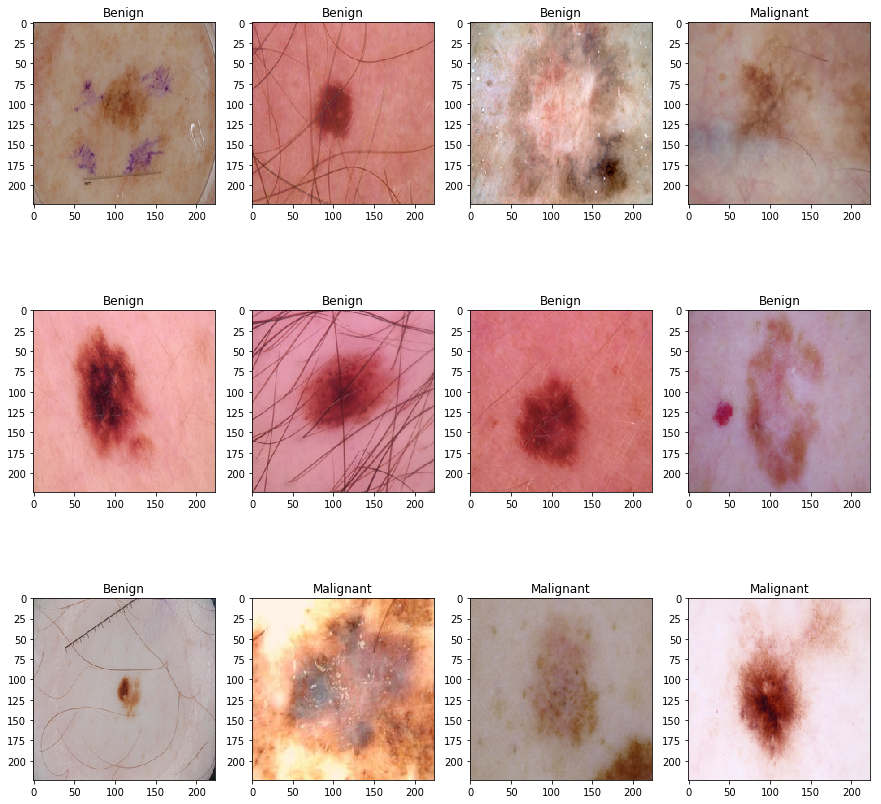

In [7]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25)
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)

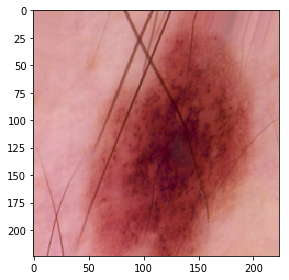

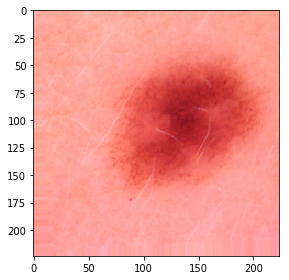

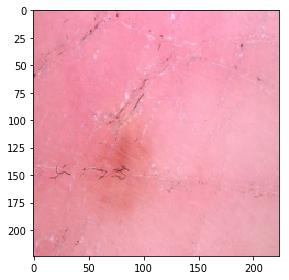

In [9]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
x3, y3 = test_generator[0]

imshow(x1[0])
imshow(x2[0])
imshow(x3[0])

# Model:

In [10]:
def build_model(backbone, lr=1e-4):
    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    return model

In [11]:
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
from tensorflow.python import ops, math_ops, state_ops, control_flow_ops
from tensorflow.python.keras import backend as K

__all__ = ['RAdam']


class RAdam(OptimizerV2):
    """RAdam optimizer.
    According to the paper
    [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf).
    """

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-7,
                 weight_decay=0.,
                 amsgrad=False,
                 total_steps=0,
                 warmup_proportion=0.1,
                 min_lr=0.,
                 name='RAdam',
                 **kwargs):
        r"""Construct a new Adam optimizer.
        Args:
            learning_rate: A Tensor or a floating point value.    The learning rate.
            beta_1: A float value or a constant float tensor. The exponential decay
                rate for the 1st moment estimates.
            beta_2: A float value or a constant float tensor. The exponential decay
                rate for the 2nd moment estimates.
            epsilon: A small constant for numerical stability. This epsilon is
                "epsilon hat" in the Kingma and Ba paper (in the formula just before
                Section 2.1), not the epsilon in Algorithm 1 of the paper.
            weight_decay: A floating point value. Weight decay for each param.
            amsgrad: boolean. Whether to apply AMSGrad variant of this algorithm from
                the paper "On the Convergence of Adam and beyond".
            total_steps: An integer. Total number of training steps.
                Enable warmup by setting a positive value.
            warmup_proportion: A floating point value. The proportion of increasing steps.
            min_lr: A floating point value. Minimum learning rate after warmup.
            name: Optional name for the operations created when applying gradients.
                Defaults to "Adam".    @compatibility(eager) When eager execution is
                enabled, `learning_rate`, `beta_1`, `beta_2`, and `epsilon` can each be
                a callable that takes no arguments and returns the actual value to use.
                This can be useful for changing these values across different
                invocations of optimizer functions. @end_compatibility
            **kwargs: keyword arguments. Allowed to be {`clipnorm`, `clipvalue`, `lr`,
                `decay`}. `clipnorm` is clip gradients by norm; `clipvalue` is clip
                gradients by value, `decay` is included for backward compatibility to
                allow time inverse decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """

        super(RAdam, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('weight_decay', weight_decay)
        self._set_hyper('total_steps', float(total_steps))
        self._set_hyper('warmup_proportion', warmup_proportion)
        self._set_hyper('min_lr', min_lr)
        self.epsilon = epsilon or K.epsilon()
        self.amsgrad = amsgrad
        self._initial_weight_decay = weight_decay
        self._initial_total_steps = total_steps

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        if self.amsgrad:
            for var in var_list:
                self.add_slot(var, 'vhat')

    def set_weights(self, weights):
        params = self.weights
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(RAdam, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        m = self.get_slot(var, 'm')
        v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = ops.convert_to_tensor(self.epsilon, var_dtype)
        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps * self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = K.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * K.minimum(local_step - warmup_steps, decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (1.0 - beta_2_power)

        m_t = state_ops.assign(m,
                               beta_1_t * m + (1.0 - beta_1_t) * grad,
                               use_locking=self._use_locking)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v_t = state_ops.assign(v,
                               beta_2_t * v + (1.0 - beta_2_t) * math_ops.square(grad),
                               use_locking=self._use_locking)
        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = state_ops.assign(vhat,
                                      math_ops.maximum(vhat, v_t),
                                      use_locking=self._use_locking)
            v_corr_t = math_ops.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = math_ops.sqrt(v_t / (1.0 - beta_2_power))

        r_t = math_ops.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                            (sma_t - 2.0) / (sma_inf - 2.0) *
                            sma_inf / sma_t)

        var_t = tf.where(sma_t >= 5.0, r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = state_ops.assign_sub(var,
                                          lr_t * var_t,
                                          use_locking=self._use_locking)

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return control_flow_ops.group(*updates)

    def _resource_apply_sparse(self, grad, var, indices):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        epsilon_t = ops.convert_to_tensor(self.epsilon, var_dtype)
        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        if self._initial_total_steps > 0:
            total_steps = self._get_hyper('total_steps', var_dtype)
            warmup_steps = total_steps * self._get_hyper('warmup_proportion', var_dtype)
            min_lr = self._get_hyper('min_lr', var_dtype)
            decay_steps = K.maximum(total_steps - warmup_steps, 1)
            decay_rate = (min_lr - lr_t) / decay_steps
            lr_t = tf.where(
                local_step <= warmup_steps,
                lr_t * (local_step / warmup_steps),
                lr_t + decay_rate * K.minimum(local_step - warmup_steps, decay_steps),
            )

        sma_inf = 2.0 / (1.0 - beta_2_t) - 1.0
        sma_t = sma_inf - 2.0 * local_step * beta_2_power / (1.0 - beta_2_power)

        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * (1 - beta_1_t)
        m_t = state_ops.assign(m, m * beta_1_t, use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)
        m_corr_t = m_t / (1.0 - beta_1_power)

        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * (1 - beta_2_t)
        v_t = state_ops.assign(v, v * beta_2_t, use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        if self.amsgrad:
            vhat = self.get_slot(var, 'vhat')
            vhat_t = state_ops.assign(vhat,
                                      math_ops.maximum(vhat, v_t),
                                      use_locking=self._use_locking)
            v_corr_t = math_ops.sqrt(vhat_t / (1.0 - beta_2_power))
        else:
            vhat_t = None
            v_corr_t = math_ops.sqrt(v_t / (1.0 - beta_2_power))

        r_t = math_ops.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                            (sma_t - 2.0) / (sma_inf - 2.0) *
                            sma_inf / sma_t)

        var_t = tf.where(sma_t >= 5.0, r_t * m_corr_t / (v_corr_t + epsilon_t), m_corr_t)

        if self._initial_weight_decay > 0.0:
            var_t += self._get_hyper('weight_decay', var_dtype) * var

        var_update = self._resource_scatter_add(var, indices, tf.gather(-lr_t * var_t, indices))

        updates = [var_update, m_t, v_t]
        if self.amsgrad:
            updates.append(vhat_t)
        return control_flow_ops.group(*updates)

    def get_config(self):
        config = super(RAdam, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'decay': self._serialize_hyperparameter('decay'),
            'weight_decay': self._serialize_hyperparameter('weight_decay'),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': self._serialize_hyperparameter('total_steps'),
            'warmup_proportion': self._serialize_hyperparameter('warmup_proportion'),
            'min_lr': self._serialize_hyperparameter('min_lr'),
        })
        return config

In [12]:
efficientnetb3 = efn.EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False
                   )

model = build_model(efficientnetb3)
model.summary()


16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,057,246
Trainable params: 4,012,670
Non-trainable params: 44,576
_________________________________________________________________


In [13]:
model.compile(
        loss='categorical_crossentropy',
        optimizer = RAdam(learning_rate=1e-3, 
                          min_lr=1e-7,
                          warmup_proportion=0.15),
        metrics=['accuracy']
    )

In [14]:
# Learning Rate Reducer
learn_control = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                  patience=5,
                                  verbose=1,
                                  factor=0.2, 
                                  min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=30,
    validation_data=val_generator,
    validation_steps = x_val.shape[0] // BATCH_SIZE,
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
64/65 [============================>.] - ETA: 1s - loss: 0.6968 - acc: 0.6890
Epoch 00001: val_acc improved from -inf to 0.52539, saving model to weights.best.hdf5
65/65 [==============================] - 88s 1s/step - loss: 0.7019 - acc: 0.6890 - val_loss: 0.7287 - val_acc: 0.5254
Epoch 2/30
64/65 [============================>.] - ETA: 0s - loss: 0.4875 - acc: 0.8049
Epoch 00002: val_acc improved from 0.52539 to 0.65234, saving model to weights.best.hdf5
65/65 [==============================] - 41s 624ms/step - loss: 0.4868 - acc: 0.8045 - val_loss: 0.6507 - val_acc: 0.6523
Epoch 3/30
64/65 [============================>.] - ETA: 0s - loss: 0.3785 - acc: 0.8352
Epoch 00003: val_acc did not improve from 0.65234
65/65 [==============================] - 40s 618ms/step - loss: 0.3755 - acc: 0.8368 - val_loss: 0.7286 - val_acc: 0.6484
Epoch 4/30
64/65 [============================>.] - ETA: 0s - loss: 0.3421 - acc: 0.8513
Epoch 00004: val_acc improved from 0.65234 to 0.65625, s

In [16]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

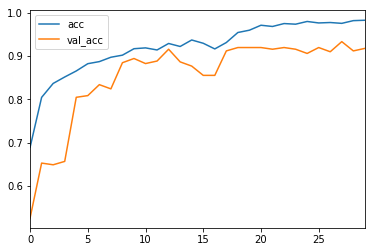

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

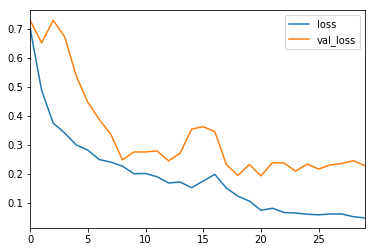

In [18]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [19]:
model.load_weights("weights.best.hdf5")

In [20]:
val_generator.reset()
Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9242424242424242

In [21]:
test_generator.reset()
Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8954545454545455

# Test Time Augmentation
A Method I have seen in Kernels of the APTOS blindness challenge, were the final prediction is the mean of predictions which went through image generators

In [22]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    test_generator = train_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)
    preds = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
    predictions.append(preds)

    del test_generator
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:25<00:00,  8.53s/it]


# Evaluation
### Accuracy Score

In [23]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8954545454545455

In [24]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

0.9227272727272727

### Confusion Matrix

Confusion matrix, without normalization
[[314  46]
 [ 23 277]]


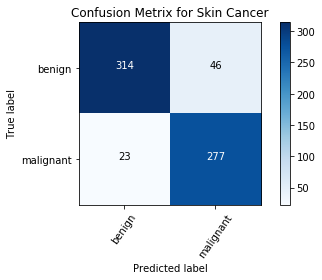

In [25]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[336  24]
 [ 27 273]]


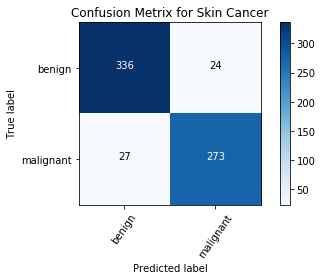

In [26]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [27]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93       360\n           1       0.92      0.91      0.91       300\n\n    accuracy                           0.92       660\n   macro avg       0.92      0.92      0.92       660\nweighted avg       0.92      0.92      0.92       660\n'

### ROC and AUC

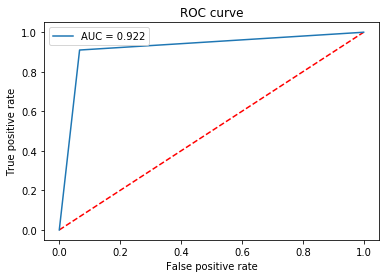

In [28]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

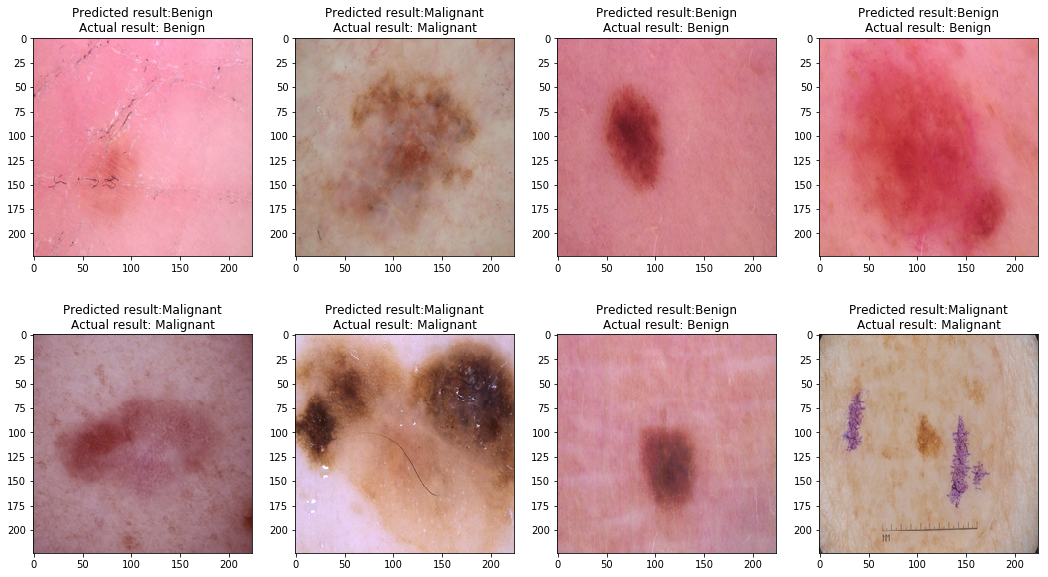

In [29]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# Save Model

In [30]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("efficientnetb0.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("efficientnet.h5")
print("Saved model to disk")

Saved model to disk
